In [5]:
from helpers import get_sides, CONST_WIDTH
from matplotlib import pyplot as plt
import numpy as np

In [6]:
def make_arrays():
    return {
        "linear_growth_width": [],
        "linear_growth_1": [],
        "linear_growth_10": [],
        "const_nnz": []
    }

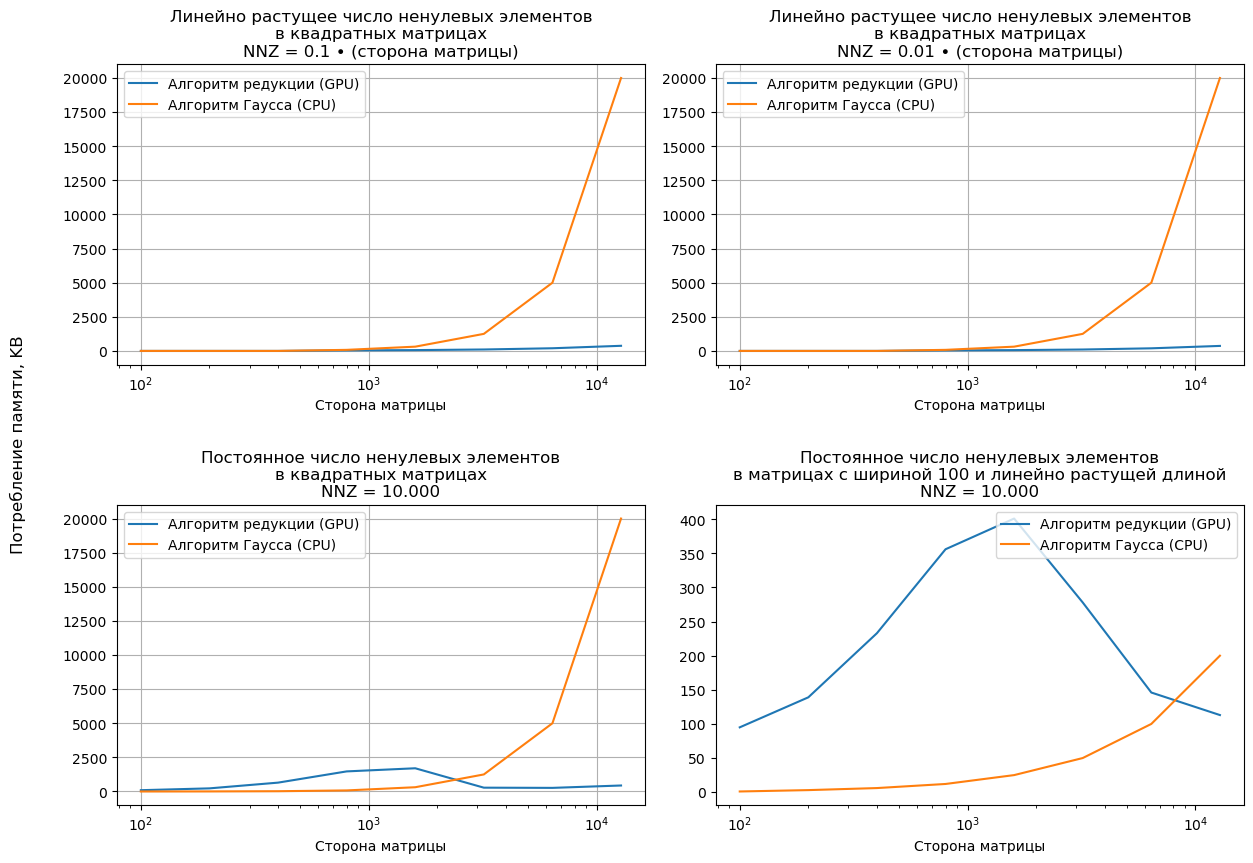

In [8]:
main_dir = "parallelrank_perfs"
use_cpu = False
sides = get_sides(False)
modifier = 1024

data = {
    "hum": make_arrays(),
    "gauss": make_arrays(),
    #"svd": make_arrays()
}

if use_cpu:
    data["cpu"] = make_arrays()

names = {
    "hum": "Алгоритм редукции (GPU)",
    "cpu":  "Алгоритм редукции (CPU)",
    "gauss": "Алгоритм Гаусса (CPU)",
    "svd": "Алгоритм SVD (GPU)"
}

def get_measurement(array, main_dir, width, height, nnz, algorithm):
    if algorithm == "svd" and width * height > 1_000_000_000:
        return
    
    if algorithm == "gauss" and width * height > 10_000_000_000: 
        return
    
    if algorithm == "hum":
        algorithm = ""
    else:
        algorithm = "_" + algorithm
    try:
        time_spent = np.load("../{}/algorithm_time_{}x{}_nnz_{}{}.npy".format(main_dir, width, height, nnz, algorithm))
    except FileNotFoundError:
        time_spent = np.load("../{}/algorithm_time_{}x{}_nnz_{}.0{}.npy".format(main_dir, width, height, nnz, algorithm))
    array.append(time_spent)

# Aggregate performance measurements
for side in sides:
    for name, nnz, shape in [
        ("linear_growth_width", CONST_WIDTH * CONST_WIDTH, (CONST_WIDTH, side)),
        ("linear_growth_1", 0.1 * side, (side, side)),
        ("linear_growth_10", 0.01 * side, (side, side)),
        ("const_nnz", CONST_WIDTH * CONST_WIDTH, (side, side))
    ]:
        nnz = int(nnz)
        width, height = shape
        for algo, arrays in data.items():
            get_measurement(arrays[name], main_dir, width, height, nnz, algo)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
#fig.suptitle('Сравнение производительности алгоритма на матрицах разных размеров')
fig.tight_layout(h_pad=8, w_pad=2)
fig.text(-0.05, 0.5, 'Потребление памяти, KB' , va='center', rotation='vertical', fontdict={'size': 12}) #'Время вычисления ранга, сек'
#fig.text(0.42, 0.03, 'Сторона матрицы', va='center', rotation='horizontal', fontdict={'size': 12})
for algo, arrays in data.items():
    array = np.array(arrays["linear_growth_1"]) // modifier
    axs[0, 0].plot(sides[:len(array)], array, label=names[algo])
axs[0, 0].title.set_text('Линейно растущее число ненулевых элементов\nв квадратных матрицах\nNNZ = 0.1 ∙ (сторона матрицы)')

for algo, arrays in data.items():
    array = np.array(arrays["linear_growth_10"]) // modifier
    axs[0, 1].plot(sides[:len(array)], array, label=names[algo])
axs[0, 1].title.set_text('Линейно растущее число ненулевых элементов\nв квадратных матрицах\nNNZ = 0.01 ∙ (сторона матрицы)')

for algo, arrays in data.items():
    array = np.array(arrays["const_nnz"]) // modifier
    axs[1, 0].plot(sides[:len(array)], array, label=names[algo])
axs[1, 0].title.set_text('Постоянное число ненулевых элементов\nв квадратных матрицах\nNNZ = 10.000')

for algo, arrays in data.items():
    array = np.array(arrays["linear_growth_width"]) // modifier
    axs[1, 1].plot(sides[:len(array)], array, label=names[algo])
axs[1, 1].title.set_text('Постоянное число ненулевых элементов\nв матрицах с шириной 100 и линейно растущей длиной\nNNZ = 10.000')

for i in range(2):
    for j in range(2):
        axs[i, j].grid()
        axs[i, j].set_xscale('log')
        #axs[i, j].set_yscale('log')
        axs[i, j].set_xlabel('Сторона матрицы')
        axs[i, j].legend()

plt.grid()
plt.show()